# Astronomical Image Reconstruction using Autoencoder
We will demonstrate image reconstruction of images of galaxies in Messier Catalog using Autoencoder. De-noising autoencoders can be trained for deconvolution and removal of noise.

In [1]:
from mirapy.data.load_dataset import load_messier_catalog_images, prepare_messier_catalog_images
from mirapy.utils import get_psf_airy, image_augmentation, append_one_to_shape, psnr
from mirapy.autoencoder.models import DeNoisingAutoencoder

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
import scipy

Using TensorFlow backend.


In [2]:
data_dir = './messier_catalog_galaxies'
img_dim = (256, 256)

npsf=64
nr=5

sigma=0.1

We will load the data set and reshape it to 256x256.

In [3]:
images = load_messier_catalog_images(data_dir, img_dim)

100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


We have 39 images in total. Firstly, we will take 4 test images and apply various data augmentation to increase the size of training set.

In [4]:
X_train, X_test = train_test_split(images, test_size=0.10, random_state=42)

In [5]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

X_train = image_augmentation(X_train, datagen, 20)

100%|██████████| 35/35 [00:02<00:00, 13.56it/s]


Following is the PSF function used for convolution:

In [6]:
def get_psf_airy(n, nr):
    xpsf = np.linspace(-1, 1, n)
    xg, yg = np.meshgrid(xpsf, xpsf)
    r = np.sqrt(xg**2+yg**2)*np.pi*nr
    psf = (scipy.special.j1(r)/r)**2
    psf = psf/psf.sum()
    return psf

You can also import it from `mirapy.utils` module.

In [7]:
psf = get_psf_airy(npsf, nr)

It is time to prepare datasets by applying convolution and adding noise from Poisson distribution.

In [9]:
X_train, x_train_noisy = prepare_messier_catalog_images(X_train, psf=psf, sigma=sigma)
X_test, x_test_noisy = prepare_messier_catalog_images(X_test, psf=psf, sigma=sigma)

We reshape the image to append `1` that represents the grayscale channel.

In [10]:
X_train = append_one_to_shape(X_train)
X_test = append_one_to_shape(X_test)
x_train_noisy = append_one_to_shape(np.array(x_train_noisy))
x_test_noisy = append_one_to_shape(np.array(x_test_noisy))

We are done with data pre-processing of images! Now it's time to build the autoencoder model. We can tune parameters to see how the network performs.

In [11]:
autoencoder = DeNoisingAutoencoder(img_dim, 'relu', 'same')

Following are the four examples of input and output images.

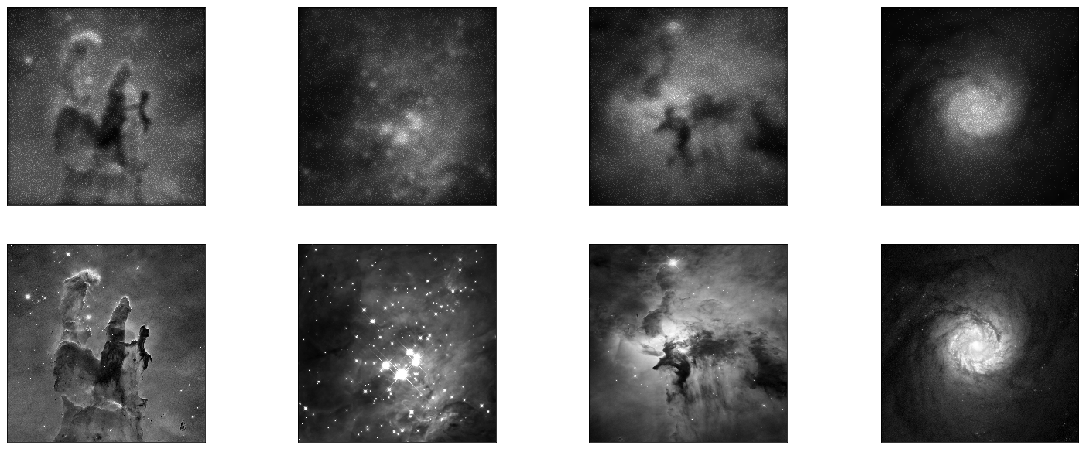

In [12]:
autoencoder.show_image_pairs(x_test_noisy, X_test, 4)

We will use `Adam` optimizer class in Keras and mean squared error as the loss function.

In [13]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(adam, 'mean_squared_error')

Here, we will use the noisy and original images of test set for validation.

In [14]:
autoencoder.train(x_train_noisy, X_train, epochs=100, validation_data=(x_test_noisy, X_test), verbose=2)

Train on 700 samples, validate on 4 samples
Epoch 1/100
 - 26s - loss: 0.0420 - val_loss: 0.1366
Epoch 2/100
 - 16s - loss: 0.0196 - val_loss: 0.0482
Epoch 3/100
 - 16s - loss: 0.0072 - val_loss: 0.0132
Epoch 4/100
 - 16s - loss: 0.0034 - val_loss: 0.0089
Epoch 5/100
 - 17s - loss: 0.0032 - val_loss: 0.0066
Epoch 6/100
 - 16s - loss: 0.0031 - val_loss: 0.0040
Epoch 7/100
 - 17s - loss: 0.0028 - val_loss: 0.0042
Epoch 8/100
 - 17s - loss: 0.0027 - val_loss: 0.0048
Epoch 9/100
 - 16s - loss: 0.0029 - val_loss: 0.0036
Epoch 10/100
 - 16s - loss: 0.0029 - val_loss: 0.0044
Epoch 11/100
 - 16s - loss: 0.0027 - val_loss: 0.0036
Epoch 12/100
 - 17s - loss: 0.0029 - val_loss: 0.0035
Epoch 13/100
 - 16s - loss: 0.0026 - val_loss: 0.0034
Epoch 14/100
 - 16s - loss: 0.0027 - val_loss: 0.0037
Epoch 15/100
 - 16s - loss: 0.0026 - val_loss: 0.0035
Epoch 16/100
 - 16s - loss: 0.0027 - val_loss: 0.0035
Epoch 17/100
 - 16s - loss: 0.0027 - val_loss: 0.0031
Epoch 18/100
 - 16s - loss: 0.0028 - val_loss: 

Following is the plot of loss function:

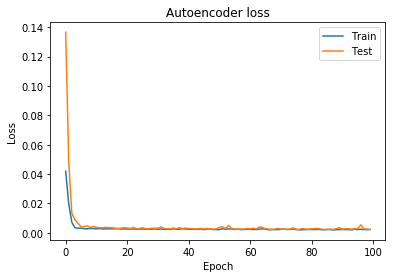

In [15]:
autoencoder.plot_history()

Now, we will denoise the test images and show the results:

In [16]:
decoded_imgs = autoencoder.predict(x_test_noisy)

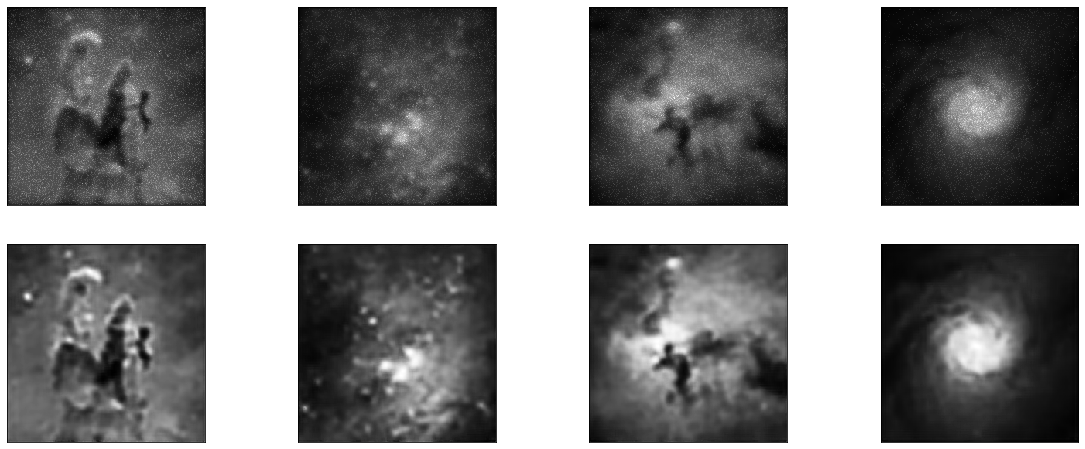

In [17]:
autoencoder.show_image_pairs(x_test_noisy, decoded_imgs, 4)

We will compute peak signal to noise ratio (PSNR) for an image:

In [18]:
psnr(X_test[0], x_test_noisy[0])

21.514661281472897